This notebook focuses on the **goal of assigning verbatim group mentions into higerh-level categories that reflects the actual groups that are being mentioned**. 
There are several different ways to refer to the same group.
For example, one can say "people with children," "people with kids", or "fathers and mothers" to refer the group *parents* (sorry for the heteronormative example).
These three different ways of referring to parents are essentially paraphrases which we want to map to the (latent) group "entity" *parents*.

The problem is that we only have the text of the verbatim group mentions and **no complete knowledge of the full list of group categories** these mentions belong to.

We thus take an **inductive approach** and cluster the observed mentions to arrive at a mapping of verbatim group mentions to the group entities they represent.

In particular, we use a pre-trained text embedding model to generate embeddings for the (predicted) verbatim group mentions in our dataset.
We then explore two different clustering approaches to organize the mentions into entity groups:

1. Density-based hierarchical clustering: This approach uses (lower-dimensional representations of) verbatim mentions' text embeddings, starts with a clustering solution that treats each mention as its own cluster, and then merges clusters based on a density criterion.
2. Graph-based community detection: This approach uses a graph representation of the mentions, where the mentions are the nodes and edges indicate pair-wise similaritiy relations between verbatim mentions  (using cosine similarity scores of mentions' embeddings as weights), and applies community detection algorithms to identify groups of mentions that are semantically relatively similarto each other than to other mentions.

## load and prepare the data

In [1]:
import os

data_path = os.path.join('..', '..', 'data')

In [2]:
import pandas as pd

fp = os.path.join(data_path, 'labeled', 'manifesto_sentences_predicted_group_mentions_spans.tsv')
# NOTE: you could also load the file with mention's predicted attribute dimension classifications

df = pd.read_csv(fp, sep='\t', usecols=['sentence_id', 'span_nr', 'text', 'label'])

In [3]:
max_spans = df['span_nr'].max()
df['mention_id'] = df['sentence_id'].astype(str) + '-' + df['span_nr'].astype(str).str.zfill(len(str(max_spans)))
del df['sentence_id']
del df['span_nr']

In [4]:
# subset to social group mentions
df = df[df.label == 'social group']

In [5]:
# remove group type labels (not needed)
del df['label']

In [6]:
# drop verbatim duplicates
df = df.groupby('text').agg({'mention_id': ('count', list)}).reset_index()
df.columns = ['text', 'n', 'mention_ids']

In [7]:
import regex
valid = df['text'].apply(lambda x: bool(regex.search(r'\p{L}', x)))
df = df[valid]

In [8]:
from mosestokenizer import MosesPunctuationNormalizer

normalizer = MosesPunctuationNormalizer('en')

df['text'] = df.text.map(normalizer).str.replace(r'["\']', '', regex=True).str.strip()

stdbuf was not found; communication with perl may hang due to stdio buffering.


In [9]:
len(df)

68316

In [10]:
# NOTE: we sample for testing purposes
df_sample = df.sample(10_000, random_state=42).reset_index(drop=True)

## Evaluation

We define a bunch of utility functions that will help us to quantitatively compare different clustering solutions.
This will allow us to evaluate the quality of the clustering solutions and to compare the two clustering approaches across and within.

### Descriptives

In [12]:
import numpy as np
from collections import Counter
from typing import List, Dict, Union
from numpy._typing import NDArray

def compute_cluster_descriptives(labels: Union[List, NDArray]) -> Dict:
    stats = {}
    # N
    stats['n_samples'] = len(labels)
    # N clusters
    stats['n_cluster'] = len(set(labels))
    # percentiles of cluster sizes
    cnts = Counter(labels)
    cluster_sizes = list(cnts.values())
    qs = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    stats['size_quantiles'] = dict(zip(qs, np.quantile(np.array(cluster_sizes), qs)))
    return stats
# # test
# import random
# tmp = [1,2,3,4,5]
# labels = random.choices(tmp, k=500)
# compute_cluster_descriptives(labels)

### Unsupervised metrics

In [13]:
# compute unsuperivsed cluster eval metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from typing import List, Dict, Union, Optional
from numpy._typing import NDArray


def compute_unsupervised_metrics(
        labels: Union[List, NDArray], 
        features: NDArray, 
        indexes: Optional[List] = None
    ) -> Dict:
    if isinstance(labels, np.ndarray):
        assert labels.ndim == 1, 'labels must be a list or 1D array'
    assert isinstance(features, np.ndarray), 'features must be a numpy array'
    assert features.ndim == 2, 'features must be a 2D array'
    if indexes is None:
        indexes = list(range(features.shape[0]))
    m = {
        'silhouette_score': silhouette_score(features[indexes], labels), # ranges from -1 to 1, higher is better
        'calinski_harabasz_score': calinski_harabasz_score(features[indexes], labels), # ranges from 0 to inf, higher is better
        'davies_bouldin_score': davies_bouldin_score(features[indexes], labels), # ranges from 0 to inf, lower is better
    }
    return m

### DEPRECATED: Supervised metrics

Because we do not have ground truth class labels that indicate group entity identities, we use pairwise must-link and cannot-link classifications for supervised evaluation.

In [ ]:
# fp = os.path.join(data_path, 'annotations', 'group_mention_categorization', 'social-group-mentions-pair-classification/llm_annotations.tsv')
# labeled = pd.read_csv(fp, sep='\t', usecols=['mention_a', 'mention_b', 'classification'])
# 
# # add data indexes for item one in pair
# labeled = pd.merge(
#     labeled,
#     df[['text']].reset_index(),
#     left_on='mention_a',
#     right_on='text',
#     how='inner',
# ).rename(columns={'index': 'index_a'}).drop(columns='text')
# 
# # add data indexes for item two in pair
# labeled = pd.merge(
#     labeled,
#     df[['text']].reset_index(),
#     left_on='mention_b',
#     right_on='text',
#     how='inner',
# ).rename(columns={'index': 'index_b'}).drop(columns='text')

In [ ]:
# label2id = {'yes': 1, 'no': 0}
# labeled['label'] = labeled['classification'].map(label2id)

In [12]:
# from sklearn.metrics import adjusted_rand_score
# from typing import List, Dict, Union, Tuple, Literal

# def compute_supervised_metrics(
#         labels: Union[List, NDArray], 
#         pairwise_constraints: List[Tuple[int, int, Literal[0, 1]]]
#     ) -> Dict:
#     """
#     Evaluates clustering performance based on pairwise must-link and cannot-link constraints.

#     Parameters:
#     - labels: A list or array of cluster assignments for each item.
#     - pairwise_constraints: A list of tuples [(idx1, idx2, label)], where
#         idx1, idx2 are indices of items, and label is 1 (must-link) or 0 (cannot-link).

#     Returns:
#     - A dictionary of evaluation metrics.
#     """
#     true_must_links = 0
#     true_cannot_links = 0
#     predicted_must_links = 0
#     predicted_cannot_links = 0
#     must_link_violations = 0
#     cannot_link_violations = 0
#     total_constraints = len(pairwise_constraints)

#     for idx1, idx2, label in pairwise_constraints:
#         same_cluster = labels[idx1] == labels[idx2]
#         if label == 1:  # Must-link constraint
#             if same_cluster:
#                 true_must_links += 1
#             else:
#                 must_link_violations += 1
#             predicted_must_links += 1
#         elif label == 0:  # Cannot-link constraint
#             if not same_cluster:
#                 true_cannot_links += 1
#             else:
#                 cannot_link_violations += 1
#             predicted_cannot_links += 1

#     # Metrics
#     must_link_precision = true_must_links / predicted_must_links if predicted_must_links > 0 else 0
#     must_link_recall = true_must_links / (true_must_links + must_link_violations) if true_must_links + must_link_violations > 0 else 0
#     cannot_link_precision = true_cannot_links / predicted_cannot_links if predicted_cannot_links > 0 else 0
#     cannot_link_recall = true_cannot_links / (true_cannot_links + cannot_link_violations) if true_cannot_links + cannot_link_violations > 0 else 0

#     # Pairwise F1 Scores
#     must_link_f1 = (
#         2 * must_link_precision * must_link_recall / (must_link_precision + must_link_recall)
#         if must_link_precision + must_link_recall > 0 else 0
#     )
#     cannot_link_f1 = (
#         2 * cannot_link_precision * cannot_link_recall / (cannot_link_precision + cannot_link_recall)
#         if cannot_link_precision + cannot_link_recall > 0 else 0
#     )

#     # Accuracy
#     pairwise_accuracy = (true_must_links + true_cannot_links) / total_constraints if total_constraints > 0 else 0

#     # Adjusted Rand Index (uses full pairwise info)
#     true_labels = []
#     predicted_labels = []
#     for idx1, idx2, label in pairwise_constraints:
#         true_labels.append(label)
#         predicted_labels.append(1 if labels[idx1] == labels[idx2] else 0)
#     adjusted_rand_idx = adjusted_rand_score(true_labels, predicted_labels)

#     # Constraint Violation Score
#     constraint_violation_score = (must_link_violations + cannot_link_violations) / total_constraints if total_constraints > 0 else 0

#     return {
#         "macro_f1": (must_link_f1 + cannot_link_f1) / 2,
#         "must_link_precision": must_link_precision,
#         "must_link_recall": must_link_recall,
#         "must_link_f1": must_link_f1,
#         "cannot_link_precision": cannot_link_precision,
#         "cannot_link_recall": cannot_link_recall,
#         "cannot_link_f1": cannot_link_f1,
#         "pairwise_accuracy": pairwise_accuracy,
#         "adjusted_rand_index": adjusted_rand_idx,
#         "constraint_violation_score": constraint_violation_score
#     }
# # test
# # pairwise_constraints = [
# #     (0, 1, 1),  # Must-link between item 0 and 1
# #     (1, 2, 0),  # Cannot-link between item 1 and 2
# #     (0, 2, 1)   # Must-link between item 0 and 2
# # ]
# # cluster_assignments = [0, 0, 1]  # Cluster labels for items 0, 1, and 2
# # 
# # compute_supervised_metrics(cluster_assignments, pairwise_constraints)

## Embed the mentions

In [ ]:
import torch
from sentence_transformers import SentenceTransformer
import torch.backends
import torch.backends.mps

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

embedding_model_id = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(embedding_model_id, device=device)

embeddings = embedder.encode(
    df_sample.text.to_list(), 
    normalize_embeddings=True, 
    convert_to_numpy=True,
    show_progress_bar=True,
)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

## Agglomerative Clustering

### DEPRECATED: Reduce embeddings to dimensions using UMAP

`deprecation note:` dim. reduction does not maintain distances, deteriorating informativeness of embeddings similarity

The mention embeddings are a huge matrix of real-valued values with shape `embeddings.shape`.
If we apply the clustering algorithms directly to this matrix, the algorithms will have to work with a high-dimensional space, which can be computationally expensive and may not be the most effective way to cluster the data.
So we first reduce the dimensionality of the embeddings using UMAP.

In [14]:
#  from sklearn.decomposition import PCA
#  
#  reducer = PCA(n_components = 'mle')
#  reducer.fit(embeddings)
#  reducer.n_components_, reducer.explained_variance_.sum()

In [15]:
# import umap

# # NOTE: dim. reduction will focus embeddings on relevant signal and speed up clustering
# # NOTE: this will take ages for the whole corpus of mentions, consider r
# # TODO: use algorithm that preserves distances between points (e.g., cosine similarity), such as 
# reducer = umap.UMAP(
#     n_components=50,
#     metric='cosine',
#     # enable determinism for reproducibility
#     random_state=42,
#     n_jobs=1,
#     verbose=True
# )
# # TODO: make this part of a custom clustering class object so it can be used in fit_transform when input is raw embedding
# reduced_embeddings = reducer.fit_transform(embeddings)

In [16]:
# # NOTE: Normalizing the data before clustering can help ensure that each feature contributes equally to the distance computation. 
# from sklearn.preprocessing import StandardScaler

# # normalize
# scaler = StandardScaler()
# # TODO: make this part of a custom clustering class object so it can be used in fit_transform when input is raw embedding
# reduced_embeddings_normalized = scaler.fit_transform(reduced_embeddings)

In [17]:
# # NOTE: we don't need the low-d embeddings anymore 
# import gc
# del reduced_embeddings
# gc.collect()

### DEPRECATED: Create the connectivity graph metric

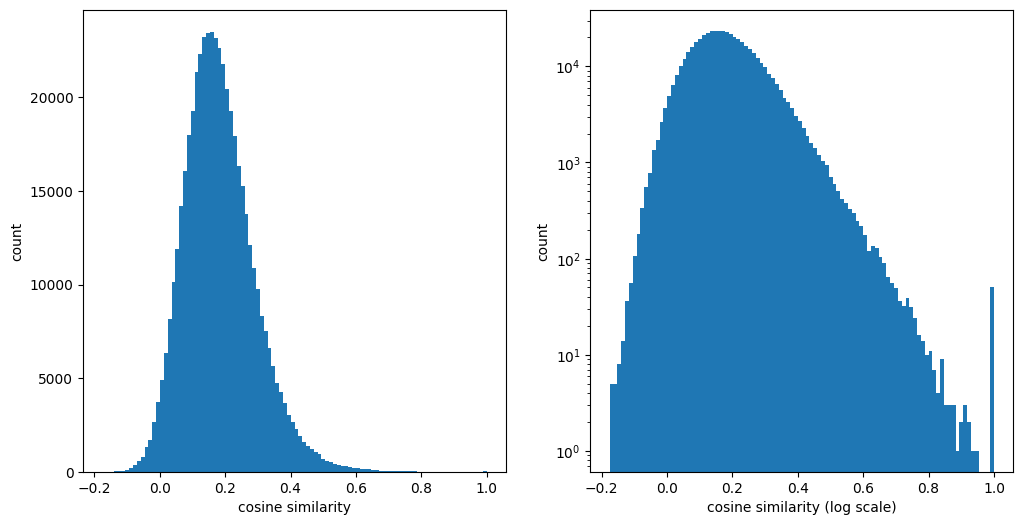

In [21]:
# let's first inspect the distributions of similarities
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

idxs = np.random.choice(embeddings.shape[0], int(embeddings.shape[0]/10), replace=False)

sims = cosine_similarity(embeddings[idxs,:], embeddings)
# plot histogram of upper triangular values
sim_scores = sims[np.triu_indices(sims.shape[0], k=1)]
# plot histogram and histogram with log-transformed y-axis side by side 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(sim_scores, bins=100)
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.hist(sim_scores, bins=100)
plt.yscale('log')
plt.xlabel('cosine similarity (log scale)')
plt.ylabel('count')
plt.show()

In [22]:
# plot quantiles 
qs = np.array([1/100, 1/10, 1, 10, 25, 50, 75, 90, 99, 99+9/10, 99+99/100])
vals = np.quantile(sim_scores, qs/100)
dict(zip([f'{q:0.2f}%'.zfill(6) for q in qs], vals.round(3)))

{'00.01%': -0.121,
 '00.10%': -0.078,
 '01.00%': -0.024,
 '10.00%': 0.057,
 '25.00%': 0.109,
 '50.00%': 0.173,
 '75.00%': 0.247,
 '90.00%': 0.323,
 '99.00%': 0.493,
 '99.90%': 0.667,
 '99.99%': 0.953}

In [17]:
# # NOTE: same as `radius_neighbors_graph` but more memory efficient due to batching
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.sparse import csr_matrix, vstack
# from tqdm import tqdm
# import gc

# # n_ = reduced_embeddings_normalized.shape[0]
# n_ = embeddings.shape[0]
# threshold = 0.90
# neighbors_graph = []
# batch_size = 5_000
# pairs = []
# for i in tqdm(range(0, n_, batch_size)):
#     # sims = cosine_similarity(reduced_embeddings_normalized[i:i+batch_size], reduced_embeddings_normalized)
#     sims = cosine_similarity(embeddings[i:i+batch_size], embeddings)
#     # set diagonal to 0
#     np.fill_diagonal(sims, 0)
    
#     # get pairs with above-threshold similarity
#     r, c = np.where(sims >= threshold)
#     r += i
#     pairs.extend(list(zip(r, c)))

#     # get for each items most similar pair (to fully connect grap)
#     c = sims.argmax(axis=1)
#     r = np.arange(sims.shape[0])+i
#     pairs.extend(list(zip(r, c)))


In [ ]:
# import networkx as nx
# # Create an undirected graph
# G = nx.Graph()
# G.add_edges_from(pairs)
# conn = nx.to_scipy_sparse_array(G, format="csr")

In [ ]:
# nns = csr_matrix(neighbors).tolil().rows
# for i in range(5):
#     print('mention:', df.text.iloc[i])
#     print('neighbors:', df.text.iloc[nns[i]].to_list())
#     print()

In [23]:
from sklearn.cluster import AgglomerativeClustering
# import pbar
from tqdm import tqdm

linkages = ['single', 'average', 'complete']
# distance_thresholds = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0] # use with UMAP embeddings
distance_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

eval_scores = {}

with tqdm(total=len(linkages) * len(distance_thresholds)) as pbar:
    for l in linkages:
        for t in distance_thresholds:
            # step pbar
            pbar.update(1)

            if (l, t) in eval_scores:
                continue
            
            # Perform agglomerative clustering
            clustering_model = AgglomerativeClustering(
                n_clusters=None, 
                linkage=l, # NOTE: average linkage considers all the distances between two clusters' data points, hence slower than single linkage
                metric='cosine', 
                # TODO: make this work: `connectivity=neighbors_graph[:n_, :n_]` to use connectivity as constraint and info to speed up the process
                distance_threshold=t, # NOTE: the lower, the more clusters (because only very similar mentions will be grouped together)
            )
            # NOTE: I changed th es parameters and now the model runs for quite some time
            # TODO: check the docu to select better arguments https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html
            # NOTE: consider tuning arguments with a training set of pairwise annotations using appropriate eval metrics 
            #       (see https://scikit-learn.org/1.5/api/sklearn.metrics.html#module-sklearn.metrics.cluster)
            clustering_model.fit(embeddings) 

            res = {}
            desc = compute_cluster_descriptives(clustering_model.labels_)
            res.update(desc)
            try:
                unsup = compute_unsupervised_metrics(clustering_model.labels_, embeddings)
                res.update(unsup)
            except:
                pass
            
            # try:
            #     sup = compute_supervised_metrics(clustering_model.labels_, labeled[['index_a', 'index_b', 'label']].values)
            #     res.update(sup)
            # except:
            #     pass

            eval_scores[(l, t)] = res

100%|██████████| 15/15 [07:15<00:00, 29.04s/it]


In [24]:
eval_scores_df = pd.DataFrame(eval_scores).T.reset_index()
eval_scores_df.rename({'level_0': 'linkage', 'level_1': 'distance_threshold'}, axis=1, inplace=True)
eval_scores_df.columns

Index(['linkage', 'distance_threshold', 'n_samples', 'n_cluster',
       'size_quantiles', 'silhouette_score', 'calinski_harabasz_score',
       'davies_bouldin_score'],
      dtype='object')

In [25]:
# turn to cateogircal
eval_scores_df.distance_threshold = pd.Categorical(eval_scores_df.distance_threshold, categories=distance_thresholds)

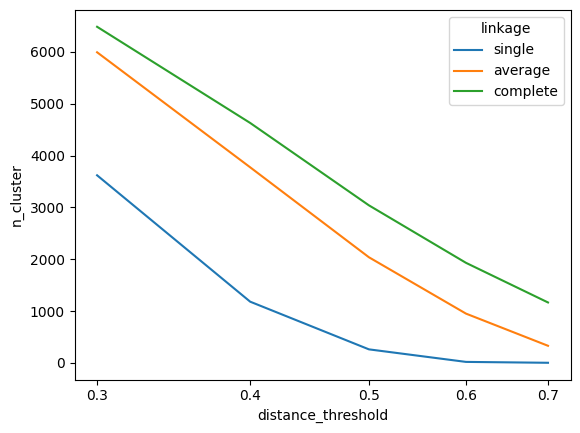

In [26]:
# plot values in column 'n_clusters' (y-axis) against 'distance_threshold' (x-axis) by 'linkage' (hue)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=eval_scores_df, x='distance_threshold', y='n_cluster', hue='linkage')
#plt.yscale('log')
plt.xscale('log')
plt.xticks(distance_thresholds, distance_thresholds)
plt.show()

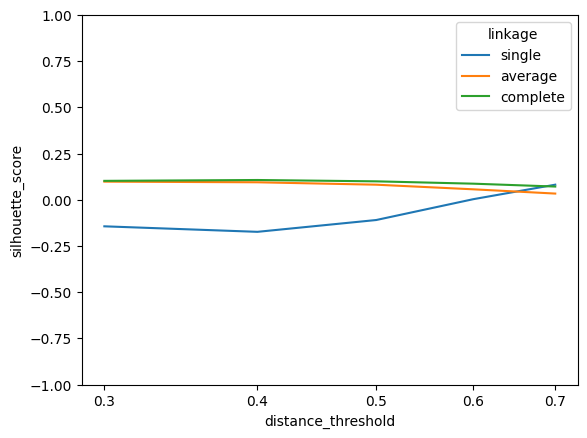

In [27]:
# plot values in column 'n_clusters' (y-axis) against 'distance_threshold' (x-axis) by 'linkage' (hue)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=eval_scores_df, x='distance_threshold', y='silhouette_score', hue='linkage')
plt.ylim(-1, 1)
plt.xscale('log')
plt.xticks(distance_thresholds, distance_thresholds)
plt.show()
# NOTE: the closer to 1 the silhouette_score, the better

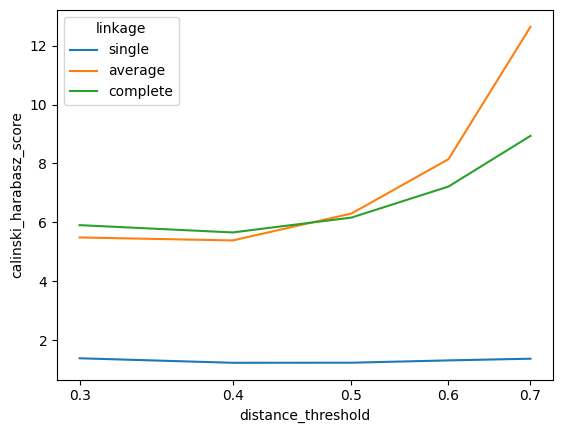

In [28]:
# plot values in column 'n_clusters' (y-axis) against 'distance_threshold' (x-axis) by 'linkage' (hue)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=eval_scores_df, x='distance_threshold', y='calinski_harabasz_score', hue='linkage')
plt.xscale('log')
plt.xticks(distance_thresholds, distance_thresholds)
plt.show()
# NOTE: the higerh the calinski_harabasz_score, the better

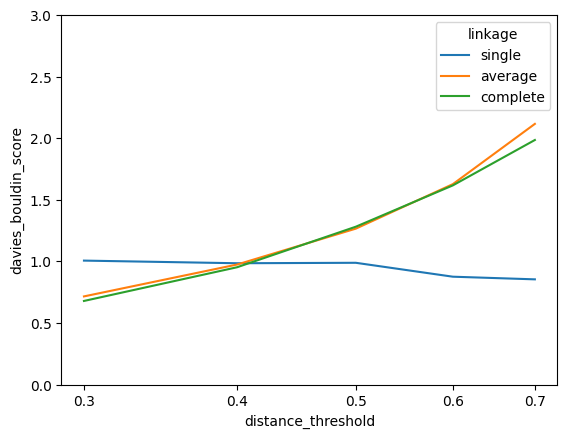

In [29]:
# plot values in column 'n_clusters' (y-axis) against 'distance_threshold' (x-axis) by 'linkage' (hue)
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=eval_scores_df, x='distance_threshold', y='davies_bouldin_score', hue='linkage')
# NOTE: the lower the davies_bouldin_score, the better
plt.ylim(0, 3)
plt.xscale('log')
plt.xticks(distance_thresholds, distance_thresholds)
plt.show()

In [30]:
# # plot values in column 'n_clusters' (y-axis) against 'distance_threshold' (x-axis) by 'linkage' (hue)
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.lineplot(data=eval_scores_df, x='distance_threshold', y='macro_f1', hue='linkage')
# plt.ylim(0, 1)
# plt.xscale('log')
# plt.xticks(distance_thresholds, distance_thresholds)
# plt.show()

### Fit final model

In [ ]:
embeddings = embedder.encode(
    df.text.to_list(), 
    normalize_embeddings=True, 
    convert_to_numpy=True,
    show_progress_bar=True,
)

Batches:   0%|          | 0/2135 [00:00<?, ?it/s]

In [32]:
clustering_model = AgglomerativeClustering(
    n_clusters=None, 
    linkage='average', # NOTE: average linkage considers all the distances between two clusters' data points, hence slower than single linkage
    metric='cosine', 
    distance_threshold=0.5 # NOTE: the lower, the more clusters (because only very similar mentions will be grouped together)
)
# NOTE: I changed th es parameters and now the model runs for quite some time
# TODO: check the docu to select better arguments https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html
# NOTE: consider tuning arguments with a training set of pairwise annotations using appropriate eval metrics 
#       (see https://scikit-learn.org/1.5/api/sklearn.metrics.html#module-sklearn.metrics.cluster)
clustering_model.fit(embeddings) # ~9.5 minutes (single linkage) / ~10 minutes (average linkage) / ~10 minutes (complete linkage)

AgglomerativeClustering(distance_threshold=0.5, linkage='average',
                        metric='cosine', n_clusters=None)

In [34]:
print(compute_cluster_descriptives(clustering_model.labels_))
print(compute_unsupervised_metrics(clustering_model.labels_, embeddings))

{'n_samples': 68316, 'n_cluster': 5789, 'size_quantiles': {0.01: 1.0, 0.05: 1.0, 0.1: 1.0, 0.25: 1.0, 0.5: 3.0, 0.75: 7.0, 0.9: 21.0, 0.95: 42.599999999999454, 0.99: 175.1199999999999}}
{'silhouette_score': 0.07390831, 'calinski_harabasz_score': 13.97089301275628, 'davies_bouldin_score': 1.4201202267881108}


In [ ]:
# save the model
import os
import json
import joblib

models_path = '../../models/mention_clustering_model/'
os.makedirs(models_path, exist_ok=True)

joblib.dump(clustering_model, os.path.join(models_path, 'model.joblib'))


params = clustering_model.get_params()
embedding_model_id = "all-MiniLM-L6-v2"
params['embedding_model'] = embedding_model_id
params['embedding_model_backend'] = 'sentence_transformers'

with open(os.path.join(models_path, 'params.json'), 'w') as f:
    json.dump(params, f)

#### inspect the clusters

In [36]:
len(set(clustering_model.labels_))

5789

In [452]:
i = 398
cidxs = np.where(labels == i)[0]
cluster = X[cidxs]
dists = cdist(cluster, cluster, metric='cosine')
c = np.argmin(dists.sum(axis=0))
print(cidxs[c])
medoid = cluster[c]

cluster.shape
dists.shape
np.argmin(dists.sum(axis=0))# 
c

3687


21

In [453]:
df.text.iloc[3687]

'Employees'

In [455]:
cluster_representatives[398]

['employees',
 'Employees',
 'individual workers',
 'workers in companies',
 'the individual workers']

In [ ]:
# compute mediods for each cluster
from scipy.spatial.distance import cdist
from tqdm import tqdm
def compute_medoids(X, labels):
    medoids = []
    for i in tqdm(sorted(set(labels))):
        cluster = X[labels == i]
        dists = cdist(cluster, cluster, metric='cosine')
        medoid = cluster[np.argmin(dists.sum(axis=0))]
        medoids.append(medoid)
    return np.array(medoids)

# compute mediods for each cluster
def get_cluster_representatives(X, labels, texts: pd.Series, n: int=1):
    representatives = []
    for i in tqdm(sorted(set(labels))):
        cidxs = np.where(labels == i)[0]
        cluster = X[cidxs,: ]
        dists = cdist(cluster, cluster, metric='cosine')
        sdists = dists.sum(axis=0)
        idxs = np.argsort(sdists)[:min(n, len(sdists))]
        reps = texts.iloc[cidxs[idxs]].tolist()
        representatives.append(reps)
    return representatives

In [401]:
cluster_representatives = get_cluster_representatives(embeddings, clustering_model.labels_, df.text, n=5)


100%|██████████| 5789/5789 [00:05<00:00, 973.64it/s] 


In [402]:
fp = os.path.join(models_path, 'representatives.json')

with open(fp, 'w') as f:
    json.dump(cluster_representatives, f)

In [ ]:
medoids = compute_medoids(embeddings, clustering_model.labels_)

100%|██████████| 5789/5789 [00:06<00:00, 839.80it/s] 


In [431]:
len(clustering_model.labels_)

68316

In [260]:
fp = os.path.join(models_path, 'cluster_medoids.bin')
with open(fp, 'wb') as f:
    np.save(f, medoids, allow_pickle=True)

In [38]:
import umap
# reduce mediods to 2D
mediods2d = umap.UMAP(
    n_components=2,
    metric='cosine',
    random_state=42,
    n_jobs=1,
    verbose=False
).fit_transform(medoids)

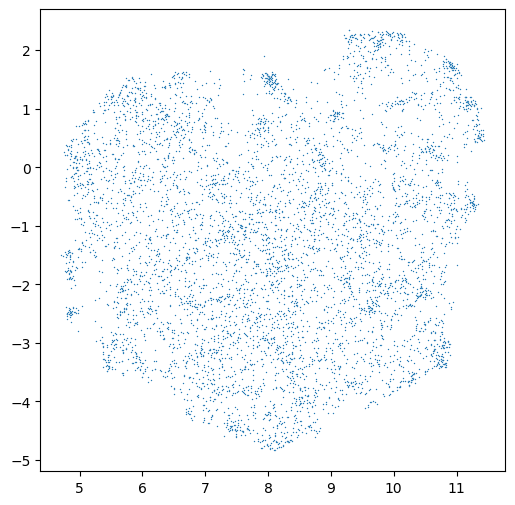

In [39]:
# plot in 2D using labels as colors
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.scatterplot(x=mediods2d[:,0], y=mediods2d[:,1], s=1) #, hue=sorted(set(clustering_model.labels_)), palette='tab20')
plt.show()

In [40]:
# assign cluster IDs to data frame
df['cluster_id'] = clustering_model.labels_

In [ ]:
fp = os.path.join(data_path, 'intermediate', 'predicted_mentions_clustered.pkl')
df.reset_index(drop=True).to_pickle(fp)

In [41]:
# number of mentions per cluster
df.cluster_id.value_counts()

cluster_id
417     845
225     796
158     710
565     685
591     684
       ... 
5536      1
2639      1
5014      1
3093      1
5028      1
Name: count, Length: 5789, dtype: int64

In [195]:
# how many have 5 or fewer mentions
for t in [5, 10, 25, 50]:
    print(f'≥ {str(t).rjust(2)} mentions:', (these:= df.cluster_id.value_counts() >= t).mean().round(3), these.sum()) # meeeh
# NOTE: this could be fixed by increasing the distance threshold, but at cost of scores

≥  5 mentions: 0.344 1993
≥ 10 mentions: 0.185 1072
≥ 25 mentions: 0.088 510
≥ 50 mentions: 0.045 259


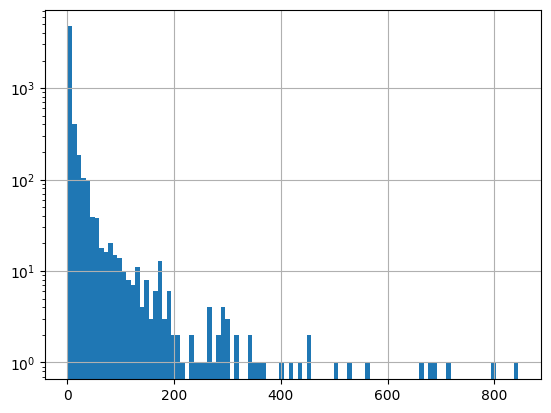

In [44]:
df.groupby('cluster_id').size().hist(bins=100).set_yscale('log')
# NOTE: underlines how very many clusters have few mentions

#### just look at the content of the biggest clusters

##### high-prevalence clustets

In [45]:
cid = df.cluster_id.value_counts().index[0]
df.query(f'cluster_id=={cid}')['text']

852                A Just Society
860          A Society of Respect
870              A caring society
878      A child-friendly society
895       A compassionate society
                   ...           
65736            whatever society
65932               whole society
65957               wider society
65960        widespread societies
68327        society of long life
Name: text, Length: 845, dtype: object

In [46]:
cid = df.cluster_id.value_counts().index[1]
df.query(f'cluster_id=={cid}')['text']

42                            poor workers
280      -educated or disadvantaged groups
305      -employed people with low incomes
360                      -income Americans
367       -income and middle-income people
                       ...                
68302                                 poor
68303                          poor groups
68304                                 poor
68341                         working poor
68342                         working poor
Name: text, Length: 796, dtype: object

In [47]:
cid = df.cluster_id.value_counts().index[2]
df.query(f'cluster_id=={cid}')['text']

2                                              COMMUNITIES
14                                        care communities
56                                       urban communities
124                                    , local communities
363                   -income and marginalized communities
                               ...                        
65782    white national, ethnic, religious and regional...
65925                                    whole communities
65926                    whole communities across the land
68100                                       your community
68110                                 your local community
Name: text, Length: 710, dtype: object

In [48]:
cid = df.cluster_id.value_counts().index[3]
df.query(f'cluster_id=={cid}')['text']

176          -abiding families who are here
344                      -friendly families
412                    -integrated families
413      -integrated families with children
448                           -off families
                        ...                
68090     youngsters from troubled families
68102                         your families
68103                           your family
68122                        your relatives
68347                         of the family
Name: text, Length: 685, dtype: object

In [49]:
cid = df.cluster_id.value_counts().index[4]
df.query(f'cluster_id=={cid}')['text']

213                      -called civilian disabled persons
270                                      -disabled persons
322             -employed persons with social disabilities
580                         -term sick and disabled people
595             -term unemployed with special disabilities
                               ...                        
67922    young people with social and emotional disabil...
67934    young people without a basic university qualif...
67963    young people, with and without disabilities, a...
68194                              youth with disabilities
68250    abnormal children who are likely to be born wi...
Name: text, Length: 684, dtype: object

#### at-threshold clusters

In [72]:
tmp = df.cluster_id.value_counts()
cid = tmp[tmp == 10].index[0]
df.query(f'cluster_id=={cid}')['text'].to_list()

['a few at the top',
 'those already at the very top',
 'those at the top',
 'those directly on the scene',
 'those in it',
 'those in the panel',
 'those on the bottom',
 'those on the frontline',
 'those on the home front',
 'those right at the bottom']

In [73]:
tmp = df.cluster_id.value_counts()
cid = tmp[tmp == 10].index[1]
df.query(f'cluster_id=={cid}')['text'].to_list()

['Our countrymen',
 'all of our countrymen',
 'our countrymen',
 'our exile countrymen',
 'the countrymen',
 'their (white) American countrymen.',
 'their countrymen',
 'these countrymen',
 'who comes to our country',
 'who is coming in and out of our country']

In [ ]:
tmp = df.cluster_id.value_counts()
cid = tmp[tmp == 10].index[2]
df.query(f'cluster_id=={cid}')['text'].to_list()

3124


['Mexicans over 18 with credentials to vote in houses in the Federal District',
 'all citizens after the age of 65',
 'citizens at the age of 18',
 'citizens of all ages',
 'citizens over 18 years of age who are supposed to take five steps toward more democracy with us',
 'citizens over the age of 16',
 'every citizen in old age',
 'fellow citizens between 20 and 40 years of age',
 'literate citizens who can exercise their right to vote responsibly from 16',
 'persons of voting age']

##### low-prevalence clusters

In [71]:
tmp = df.cluster_id.value_counts()
cid = tmp[tmp == 10].index[0]
df.query(f'cluster_id=={cid}')['text'].to_list()

['a few at the top',
 'those already at the very top',
 'those at the top',
 'those directly on the scene',
 'those in it',
 'those in the panel',
 'those on the bottom',
 'those on the frontline',
 'those on the home front',
 'those right at the bottom']

In [50]:
cid = df.cluster_id.value_counts().index[-1]
df.query(f'cluster_id=={cid}')['text'].to_list()

['small EVA subjects']

In [51]:
cid = df.cluster_id.value_counts().index[-2]
df.query(f'cluster_id=={cid}')['text'].to_list()

['highly qualified specialists at the Institute of Mineral Resources']

In [52]:
cid = df.cluster_id.value_counts().index[-3]
df.query(f'cluster_id=={cid}')['text'].to_list()

['him who bore the battle']

#### getting key terms from clusters

Given all mentions in a cluster, we can contrast their bag-of-words token frequencies with all other clusters to find distinctive/key terms for a cluster (would need to iterate over all clusters thoug).

In [196]:
from utils.fighting_words import bayes_compare_language # source https://github.com/jmhessel/FightingWords/blob/master/fighting_words_py3.py
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

vectorizer = CountVectorizer(
    stop_words=stopwords.words('english'),
    ngram_range=(1, 3), 
    max_df = 0.5
)

In [ ]:
# import pandas as pd
# import numpy as np

# from sklearn.feature_extraction.text import CountVectorizer
# from nltk.corpus import stopwords

# vectorizer = CountVectorizer(
#     stop_words=stopwords.words('english'),
#     ngram_range=(1, 3), 
#     max_df = 0.5
# )

# def compute_c_tf_idf(df, vectorizer, text_col: str='text', cluster_id_col: str='cluster_id', threshold=0.0):
    
#     # Step 1: Aggregate texts per cluster
#     grouped_texts = df.groupby(cluster_id_col)[text_col].apply(lambda x: " ".join(x))
#     idx2cluster = {i: c for i, c in enumerate(grouped_texts.index)}

#     # Step 2: Compute term-document matrix (TF)
#     X = vectorizer.fit_transform(grouped_texts)  # Shape: (num_clusters, num_terms)

#     # Step 3: Compute IDF
#     N = len(grouped_texts)  # Number of clusters
#     term_occurrences = np.array((X > 0).sum(axis=0)).flatten()  # Count clusters per term
#     idf = np.log(N / (1 + term_occurrences))  # Add 1 to avoid division by zero

#     # Step 4: Normalize TF values per topic
#     tf = X.toarray()  # Convert to dense array
#     topic_lengths = tf.sum(axis=1, keepdims=True)  # Sum of words per topic
#     tf_normalized = np.divide(tf, topic_lengths, where=topic_lengths != 0)  # Avoid div by 0

#     # Step 5: Compute c-TF-IDF
#     c_tf_idf = tf_normalized * idf  # Element-wise multiplication

#     # Step 6: Convert to long-format DataFrame
#     r, feats = np.where(c_tf_idf>0.0)
#     feature_names = vectorizer.get_feature_names_out()
#     c_tf_idf_long = pd.DataFrame({cluster_id_col: pd.Series(r).map(idx2cluster), 'term': feature_names[feats], 'occurences': tf[r, feats], 'score': c_tf_idf[r, feats]})
    

#     # Step 7: Filter out low-score terms
#     c_tf_idf_long = c_tf_idf_long[c_tf_idf_long["score"] >= threshold]

#     # Step 8: Rank terms within each topic
#     c_tf_idf_long = c_tf_idf_long.sort_values(by=["cluster_id", "score"], ascending=[True, False])

#     return c_tf_idf_long

# scores = compute_c_tf_idf(df=df[df.cluster_id.isin(these_clusters)], vectorizer=vectorizer)

In [197]:
c_id = example_id = df.cluster_id.value_counts().index[0]

fw = bayes_compare_language(
    l1=df.loc[np.logical_and(df.cluster_id.notnull(), df.cluster_id==c_id), 'text'].to_list(),
    l2=df.loc[np.logical_and(df.cluster_id.notnull(), df.cluster_id!=c_id), 'text'].to_list(),
    cv=vectorizer,
)
fw = pd.DataFrame(fw, columns=['word', 'score']).sort_values('score', ascending=False)

fw[fw.score >= 1.96] # NOTE: `score` is a z-score and hence we can only use as "significantly" distinct terms

Vocab size is 183330
Comparing language...


,word,score
183329,society,75.799834
183328,societies,27.138250
183327,equal,14.930287
183326,solidary,13.777264
183325,society everyone,13.029377
...,...,...
182722,takes care,2.018961
182710,conditions,1.996760
182708,grow,1.988247
182709,offer,1.988247


In [209]:
# NOTE: given how long this takes, iterating over all clusters is not feasible 
#  but could be done for relatively large clusters, e.g.
(these:= df.cluster_id.value_counts() >= 25).sum()

510

In [210]:
these_clusters = these[these].index.to_list()
these_clusters[:5]

[417, 225, 158, 565, 591]

In [213]:
fighting_words = {}

for cid in tqdm(these_clusters):
    fw = bayes_compare_language(
        l1=df.loc[np.logical_and(df.cluster_id.notnull(), df.cluster_id==cid), 'text'].to_list(),
        l2=df.loc[np.logical_and(df.cluster_id.notnull(), df.cluster_id!=cid), 'text'].to_list(),
        cv=vectorizer,
    )
    fw = pd.DataFrame(fw, columns=['word', 'score']).sort_values('score', ascending=False)
    fighting_words[cid] = fw[fw.score >= 1.96]

  0%|          | 0/510 [00:00<?, ?it/s]

100%|██████████| 510/510 [3:01:43<00:00, 21.38s/it]  


`@Leonce`: these keyword summaries are already very helpful in my opinion.

- they are good, statistically-informed bag-of-word summaries
- they enable keyword-based search with a very limited risk for bycatch (e.g., by focusing on n-grams with z-scores ≥ 1.96 or even higher, e.g., 2.576 for 99% confidence)

Woudl _not_ solve the issue of multimembership assignment of mentions that should belong to more than one group category (e.g. "unemployed people in rural areas")

In [222]:
cluster_fighting_words = pd.concat(fighting_words).reset_index(level=0, names='cluster_id').reset_index(drop=True)

In [235]:
fp = os.path.join(models_path, 'cluster_keywords.pkl')
cluster_fighting_words.to_pickle(fp)

In [115]:
from scipy.stats import norm
norm.ppf((1 + 99.9999/100) / 2)

4.891638475671085

In [403]:
import os
from pathlib import Path
import joblib
import json
from sentence_transformers import SentenceTransformer

from dataclasses import dataclass
from typing import Union, List
from pandas import DataFrame
from numpy.typing import NDArray

@dataclass
class ClusteredMentions:
    model: "AgglomerativeClustering"
    embedder: "SentenceTransformer"
    representatives: List[List[str]]
    mediods: "NDArray"
    keywords: "DataFrame"

    def __post_init__(self):
        self.n_clusters = self.mediods.shape[0]
        self.embedding_dimension = self.mediods.shape[1]
    
    @classmethod
    def from_fitted(cls, model_path: Union[str, Path]):
        if isinstance(model_path, str):
            model_path = Path(model_path)
        if not model_path.exists(): raise FileNotFoundError(f"model_path '{str(model_path)}' does not exist")
        if not model_path.is_dir(): raise NotADirectoryError(f"model_path '{str(model_path)}' is not a directory")
        req_files = ['model.joblib', 'params.json', 'representatives.json', 'cluster_medoids.bin', 'cluster_keywords.pkl']
        files = [f.name  for f in Path(model_path).glob('*')]
        missing = [f for f in req_files if f not in files]
        if len(missing) > 0:
            raise FileNotFoundError(f"model_path '{str(model_path)}' does not contain required files {missing}")
        
        model = joblib.load(os.path.join(model_path, 'model.joblib'))
        
        with open(os.path.join(model_path, 'params.json'), 'r') as f:
            params = json.load(f)
        
        if 'embedding_model_backend' not in params or params['embedding_model_backend'] != 'sentence_transformers':
            raise ValueError('')
        embedder = SentenceTransformer(params['embedding_model'])
        
        with open(os.path.join(model_path, 'representatives.json'), 'r') as f:
            representatives = json.load(f)

        with open(os.path.join(model_path, 'cluster_medoids.bin'), 'rb') as f:
            medoids = np.load(f)
        
        keywords = pd.read_pickle(os.path.join(models_path, 'cluster_keywords.pkl'))

        return cls(model, embedder, representatives, medoids, keywords)

    def __repr__(self):
        return f"ClusteredMentions(n_clusters={self.n_clusters})"

clustered_mentions = ClusteredMentions.from_fitted(models_path)
clustered_mentions

ClusteredMentions(n_clusters=5789)

In [404]:
def search_clusters(
    query: Union[str, List[str]],
    threshold: float=0.5
):
    if isinstance(query, str): 
        query = [query]
    embs = clustered_mentions.embedder.encode(query, normalize_embeddings=True, convert_to_numpy=True)
    emb = embs.mean(axis=0)
    sims = clustered_mentions.embedder.similarity_pairwise(clustered_mentions.mediods, emb.reshape((1, -1)))
    ranked = sims.argsort(descending=True).numpy()
    idxs = ranked[np.where(sims[ranked]>threshold)]
    return ranked[idxs], sims[idxs].numpy()

In [ ]:
query = ['workers', 'employees']


tensor([0.8456])

In [465]:
queries = [
    'workers', 
    'working class', 
    'working people', 
    'those working in industry',
    'those working in factories',
    'blue collar workers',
]
idxs, sims = search_clusters(queries, threshold=0.5)

{(i, s): clustered_mentions.representatives[i] for i, s in zip(idxs, sims)}
# clustered_mentions.keywords[clustered_mentions.keywords.cluster_id.isin(idxs.tolist())]

{(380, 0.8019204): ['Volunteers in blue light organizations',
  'Volunteers at blue light organizations',
  'blue light personnel',
  'people in the blue',
  'those active with blue light organisations on public transportation or on entrance to sports, educational or cultural institutions'],
 (1530, 0.798354): ['the man living on wages and wages',
  'A man who receives a gross monthly salary of 5,000 F,',
  'a worker with a monthly gross wage of 250 thousand forints',
  'man employed'],
 (723, 0.779836): ['Residents',
  'residents',
  'local residents',
  'Local residents',
  'The residents'],
 (95, 0.77234554): ['layer of society',
  'the layers of the population',
  'layers of the population',
  'all layers of society',
  'the layers'],
 (4441,
  0.765492): ['those affected by bindingly established noise emission limits to protect health'],
 (5479,
  0.76358163): ['A member of parliament who is a district chief of profession and criticizes his land chief'],
 (762, 0.73508424): ['comp

In [466]:
queries = [
    'dentists', 
]
idxs, sims = search_clusters(queries, threshold=0.5)

{(i, s): clustered_mentions.representatives[i] for i, s in zip(idxs, sims)}
# clustered_mentions.keywords[clustered_mentions.keywords.cluster_id.isin(idxs.tolist())]

{(544, 0.7914879): ['Service Members',
  'service members',
  'those who operate the service',
  'the service users',
  'service users'],
 (4454, 0.5712752): ['begg'],
 (3096, 0.56076217): ['custodial managers working in England and Wales'],
 (1156, 0.54527575): ['parking guards',
  'parking',
  'park guards',
  'those who need to park at work',
  'park-keepers'],
 (2626, 0.535623): ['others paying for visits',
  'the recipients of fees for public benefit activities'],
 (3632, 0.53095126): ['patients without a referral letter'],
 (2918, 0.51604044): ['all clotto'],
 (4162,
  0.51534843): ['people who need to be physically present at work, such as a seller or nurse'],
 (2811, 0.50912654): ['custodians',
  'custodian',
  'Custodians of the land we',
  'Custodians of the Prison',
  'a qualified custodian assistant'],
 (905,
  0.50581086): ['a person who previously worked for one of the top business representatives and who is also in a state of conflict of interest as the head of ABW', 'a 

In [476]:
clustered_mentions.keywords.query("word=='dentists'")# [clustered_mentions.keywords.word.isin(queries)].sort_values('score', ascending=False)

,cluster_id,word,score
26120,1212,dentists,2.508622
35730,229,dentists,7.721016


In [484]:
expls = clustered_mentions.keywords.query('cluster_id==1212')
expls[expls.word.str.contains('dentist')]

,cluster_id,word,score
26120,1212,dentists,2.508622


In [485]:
clustered_mentions.representatives[229]
# clustered_mentions.representatives[1212]

['dental health professionals',
 'dental professionals',
 'Dentists',
 'dentists',
 'the dentists']

tensor([0.1209, 0.2503, 0.3468,  ..., 0.1102, 0.0973, 0.2358])

In [261]:
edim = embedder.get_sentence_embedding_dimension()

with open(os.path.join(models_path, 'cluster_medoids.bin'), 'rb') as f:
    meds = np.load(f)

meds.shape

(5789, 384)

## Community detection

In [ ]:
# !pip install cdlib=0.4.0
# !pip install igraph==0.11.8 leidenalg==0.10.2
# !pip install pycombo==0.1.8

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### construct weighted graph

remember this 👇

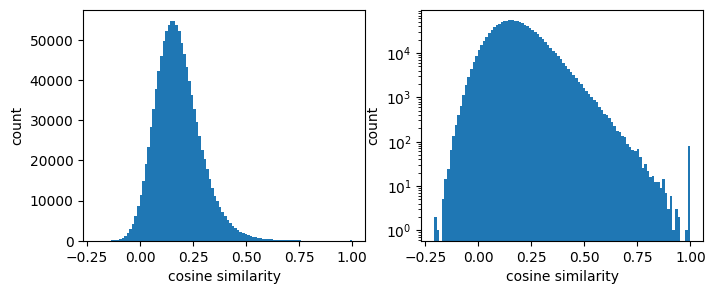

{'00.01%': -0.12211504470035434,
 '00.10%': -0.08137406273186207,
 '01.00%': -0.027428350411355495,
 '10.00%': 0.053512196987867355,
 '25.00%': 0.10590158216655254,
 '50.00%': 0.16982804238796234,
 '75.00%': 0.24237775057554245,
 '90.00%': 0.31891465485095977,
 '99.00%': 0.49078577756881714,
 '99.90%': 0.6595805083513275,
 '99.99%': 0.873419501203214}

In [137]:
# plot histogram and histogram with log-transformed y-axis side by side 
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(sim_scores, bins=100)
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.subplot(1, 2, 2)
plt.hist(sim_scores, bins=100)
plt.yscale('log')
plt.xlabel('cosine similarity')
plt.ylabel('count')
plt.show()

# plot quantiles 

qs = np.array([1/100, 1/10, 1, 10, 25, 50, 75, 90, 99, 99+9/10, 99+99/100])
dict(zip([f'{q:0.2f}%'.zfill(6) for q in qs], np.quantile(sim_scores, qs/100)))

In [160]:
for s in [0.25, 0.33, 0.5, 0.75]:
    print(f'{(sim_scores >= s).mean()*100:0.3f}% (N~={int((sim_scores >= s).mean()*embeddings.shape[0])}) of pairs have simalirity >= {s}')
for s in [0, -0.1, -0.25]:
    print(f'{(sim_scores <= s).mean()*100:0.3f}% (N~={int((sim_scores <= s).mean()*embeddings.shape[0])}) of pairs have simalirity <= {s}')

22.980% (N~=3446) of pairs have simalirity >= 0.25
8.664% (N~=1299) of pairs have simalirity >= 0.33
0.884% (N~=132) of pairs have simalirity >= 0.5
0.032% (N~=4) of pairs have simalirity >= 0.75
2.517% (N~=377) of pairs have simalirity <= 0
0.041% (N~=6) of pairs have simalirity <= -0.1
0.000% (N~=0) of pairs have simalirity <= -0.25


In [187]:
import networkx as nx

# NOTE: same as `radius_neighbors_graph` but more memory efficient due to batching
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, vstack
from tqdm import tqdm
import gc

# init a networkx graph
G = nx.Graph()
# init nodes
G.add_nodes_from(range(embeddings.shape[0]))

pos_threshold = 0.50
neg_threshold = 0.00

batch_size = 2_500
for i in tqdm(range(0, embeddings.shape[0], batch_size)):
    sims = cosine_similarity(embeddings[i:i+batch_size], embeddings)
    # set diagonal and lower triangle to 0
    np.fill_diagonal(sims, 0)
    sims = np.triu(sims)
    # must-link constraints 
    p, q = np.where(sims >= pos_threshold)
    w = sims[p, q]
    p += i
    G.add_weighted_edges_from(zip(p, q, w))
    # # cannot-link constraints
    # p, q = np.where(sims <= neg_threshold)
    # w = sims[p, q]
    # p += i
    # G.add_weighted_edges_from(zip(p, q, w))

100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


In [188]:
# get graph size
len(G), len(G.edges)

(15000, 1018958)

In [203]:
for p, q  in [e for i, e in enumerate(G.edges) if i < 400]:
    w = G.edges[p, q]["weight"]
    if w > 0.7:
        print(f'{w:0.3f}: "{df.text.iloc[p]}"\t"{df.text.iloc[q]}"')

0.710: "the competent staff in public authorities"	"employees in the public administration"
0.744: "the competent staff in public authorities"	"heads of public authorities and public services"
0.705: "the competent staff in public authorities"	"The employees of the public service"
0.705: "the competent staff in public authorities"	"the staff councils"
0.733: "the competent staff in public authorities"	"the public sector staff"
0.726: "the competent staff in public authorities"	"The employees of the public administration"
0.713: "the competent staff in public authorities"	"the government staff"
0.766: "judicial magistrates"	"court officers"
0.809: "judicial magistrates"	"the top magistrates"
0.721: "judicial magistrates"	"The holders of the highest magistrates"
0.771: "judicial magistrates"	"the magistrate"
0.901: "judicial magistrates"	"magistrates"
0.819: "judicial magistrates"	"individual magistrates"
0.725: "judicial magistrates"	"tax magistrates"
0.813: "judicial magistrates"	"fede

In [252]:
# crisp
from cdlib.algorithms import leiden, greedy_modularity, lswl_plus, surprise_communities, pycombo, infomap
# overlapping 
from cdlib.algorithms import dpclus, graph_entropy
# coms = leiden(G, weights='weight') # some very large components
# coms = greedy_modularity(G, weight='weight') # runs too long
# coms = lswl_plus(G, merge_outliers=False)
# coms = surprise_communities(G, weights='weight') # doesnt run
# coms = infomap(G, flags='edge_weights="weight"') # okayish
#coms = dpclus(G, weights='weight') #runs too long
coms = graph_entropy(G, weights='weight') #runs too long

KeyboardInterrupt: 

In [245]:
coms.newman_girvan_modularity()
# NOTE: the higher the better

FitnessResult(min=None, max=None, score=0.5841919767114447, std=None)

In [246]:
labels_mapping = {i: c[0] for i, c in coms.to_node_community_map().items()}
labels = list(labels_mapping.values())

In [247]:
compute_cluster_descriptives(labels)

{'n_samples': 15000,
 'n_cluster': 517,
 'size_quantiles': {0.01: 1.0,
  0.05: 1.0,
  0.1: 1.0,
  0.25: 1.0,
  0.5: 2.0,
  0.75: 9.0,
  0.9: 44.20000000000027,
  0.95: 124.0,
  0.99: 595.7599999999977}}

In [248]:
compute_unsupervised_metrics(labels, embeddings, indexes=list(labels_mapping.keys()))

{'silhouette_score': 0.028178975,
 'calinski_harabasz_score': 12.894427799259299,
 'davies_bouldin_score': 1.5745794113810636}

In [ ]:
eval(clustering_model.labels_, reduced_embeddings_normalized[:n_])

{'silhouette_score': 0.50098974, 'davies_bouldin_score': 0.46287228342886194}

In [250]:
df.iloc[coms.communities[1]].text

26                           ill and unemployed workers
30                                  Those working in it
38                               discouraged unemployed
47                           the most skilled employees
59                            hard-to-employable people
                              ...                      
14908                       the American worker at home
14924                     People who now work part-time
14930                              a permanent employee
14957                          Those who work regularly
14984    groups of employees in the healthcare sector (
Name: text, Length: 1013, dtype: object

In [47]:
# get upper diagonal indexes
i = 0
sims = cosine_similarity(reduced_embeddings_normalized[i:i+batch_size], reduced_embeddings_normalized)
# set diagonal and lower triangle to 0
sims = np.triu(sims)

In [51]:
p, q = np.where(sims >= 0.99)
w = sims[p, q]
len(w)

946884

In [52]:
G.add_weighted_edges_from(zip(p, q, w))

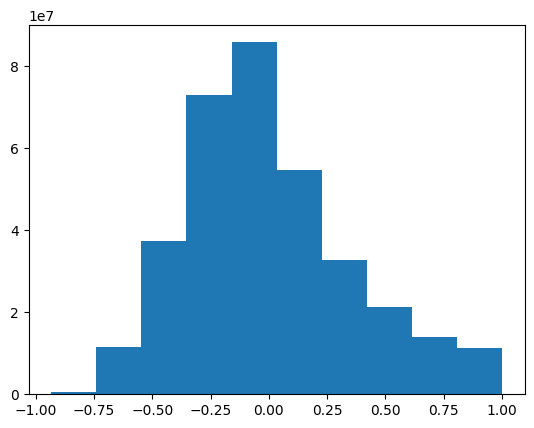

In [45]:
# get values in uper triangle
upper = np.triu(sims, k=1)
# plot historgram of similarities

from matplotlib import pyplot as plt
plt.hist(upper.ravel())
plt.show()

## Appendix

### What else to do with embeddings

#### Finding nearest neighbors

Given mentions' representation in the (reduced-*d*) embedding space, we can search for nearest neighbors to a mention.
This can be used to find similar mentions or to find mentions that belong to the same higher-level group.

Two ways:

1. fixed number of neighbors per mention (using `kneighbors_graph`)
2. fixed distance threshold (using `radius_neighbors_graph` or my more space-efficient implementation below)

**_NOTE:_** We can also use neighborhood information to semi-supervise agglomarative clustering with "connectivity" constraints

You can define pairs of mentions that should be in the same cluster. 
This can be done by adding a "connectivity" constraint to `AgglomerativeClustering`'s `connectivity` argument.
See https://scikit-learn.org/stable/modules/clustering.html#adding-connectivity-constraints

These positive examples pairs could come from human annotation.

But one automated way if finding examples is using sklearn's `kneighbors_graph` as suggested [here](https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_clustering.html#sphx-glr-auto-examples-cluster-plot-agglomerative-clustering-py):

#### Fixed number of neighbors

main disadvantage: setting a cutoff can ignore the density of clusters (some mentions might cluster densely, i.e., have many very similar neighbors, while for other mentions the five nearest neighbors are comparatively dissimilar)

In [ ]:
from sklearn.neighbors import kneighbors_graph
knn_graph = kneighbors_graph(reduced_embeddings_normalized, 5, include_self=False)
# NOTE: using normalized reduced embeddings here (could use `embeddings` but it's slower)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# get list of lists of items nearest neighbors (thanks to https://stackoverflow.com/a/72519774)
nns = knn_graph.tolil().rows

In [ ]:
for i in range(5):
    print('mention:', df.text.iloc[i])
    print('neighbors:', df.text.iloc[nns[i]].to_list())
    print()
# Mostly finds close-to-verbatim paraphrases

mention: everyone
neighbors: ['Everyone', 'EVERYONE', 'everyone the same', 'everyone with', 'Everyone but']

mention: Indigenous peoples
neighbors: ['indigenous peoples', 'the indigenous peoples', 'the indigenous inhabitants', 'indigenous peasants', 'indigenous speakers']

mention: workers
neighbors: ['Workers', 'the port workers', 'the workers and', 'MINA workers', 'workers in them']

mention: Australians
neighbors: ['Australians as', 'other Australians', 'AUSTRALIANS', 'Australian people', 'ordinary Australians']

mention: the world's highest per capita users of water
neighbors: ["the world's heaviest water users", 'whoever deliberately swings with water by using eco-friendly washing powder,', 'those who really smust with water', "the world's most inefficient users of water", 'a user of water']



#### Fixed distance neighborhood

main disadvantage: what's a good threshold?

In [ ]:
# NOTE: same as `radius_neighbors_graph` but more memory efficient due to batching
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import gc

n_ = reduced_embeddings_normalized.shape[0]

nns = []
batch_size = 5_000
for i in tqdm(range(0, n_, batch_size)):
    sims = cosine_similarity(reduced_embeddings_normalized[i:i+batch_size], reduced_embeddings_normalized)
    # get indexes where similarity is above threshold
    for i in range(sims.shape[0]):
        neighbors = np.where(sims[i] >= 0.975)[0]
        # sort by similarity (decreasing)
        neighbors = neighbors[np.argsort(sims[i, neighbors])[::-1]]
        # NOTE: could also get tupple of mention and cos similarity score ;)
        # remove self
        neighbors = neighbors[neighbors != i]
        # append
        nns.append(neighbors.tolist())

gc.collect()

100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


0

In [ ]:
for i in range(5):
    print('mention:', df.text.iloc[i])
    print('neighbors:', df.text.iloc[nns[i]].to_list())
    print()
# Last example shows that high cosine also retrieves related but other-group examples ('wastewater managers', 'watermen')

mention: everyone
neighbors: ['Everyone', 'EVERYONE', 'everyone (', 'Everyone,', 'everyone the same', 'everyone,', 'everyone with', 'everyone apart from', 'everybody', 'everyone –', 'Everyone but', 'Everyone, whether', 'Everybody', 'everyone the', 'everyone as', 'everybody else', 'everyone – even on', 'Everyone else', 'everyone else', 'almost everyone', 'everyone gives', 'Almost everyone', 'everyone at a low level', 'almost anyone', 'everyone (starting with the least)', 'everyone in', 'everyone, including', 'everyone, from', 'everyone, regardless', 'everyone regardless', 'everyone other than', 'everyone from', 'Almost everyone at some point in their lives', 'virtually everyone', 'everyone, regardless of', 'anyone from', 'all people, regardless', 'people regardless', 'all other people', 'everyone, even in their own', 'All people,', 'Anyone on the Internet', 'any people', 'everyone consumed', 'all people', 'every other people', 'all other peoples', 'no person in the United States', 'all 